In [67]:
# necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

from pathlib import Path
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# reading in data
acct_df = pd.read_parquet(Path('../../q2data/q2-ucsd-acctDF.pqt'))
cons_df = pd.read_parquet(Path('../../q2data/q2-ucsd-consDF.pqt'))
trxn_df = pd.read_parquet(Path('../../q2data/q2-ucsd-trxnDF.pqt'))

In [3]:
# changing column types for processing
acct_df.balance_date = pd.to_datetime(acct_df.balance_date)
acct_df = acct_df.astype({'prism_consumer_id': int, 'prism_account_id': int})

cons_df.evaluation_date = pd.to_datetime(cons_df.evaluation_date)
cons_df = cons_df.astype({'prism_consumer_id': int})

trxn_df.posted_date = pd.to_datetime(trxn_df.posted_date)
trxn_df = trxn_df.astype({'prism_consumer_id': int, 'prism_transaction_id': int})

In [4]:
display(acct_df, cons_df, trxn_df)

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0,0.0
1,1,2021-07-01,626.0,0.0
2,2,2021-05-01,680.0,0.0
3,3,2021-03-01,734.0,0.0
4,4,2021-10-01,676.0,0.0
...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN
14996,14996,2022-01-15,625.0,NaN
14997,14997,2022-01-31,688.0,NaN
14998,14998,2022-03-08,722.0,NaN


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.96,DEBIT,2022-03-11
6407317,10533,6405305,12,63.48,DEBIT,2022-03-30
6407318,10533,6405306,12,53.99,DEBIT,2022-03-30
6407319,10533,6405307,12,175.98,DEBIT,2022-03-31


In [5]:
# different account types
acct_df.account_type.value_counts()

account_type
CHECKING           15467
SAVINGS             7751
CREDIT CARD          691
LOAN                 127
LINE OF CREDIT        93
CONSUMER              73
BROKERAGE             66
CD                    45
MONEY MARKET          36
AUTO                  29
MORTGAGE              22
PREPAID               19
OTHER                 12
IRA                    9
ROTH                   5
CASH MANAGEMENT        5
401K                   4
RETIREMENT             3
STUDENT                2
HSA                    2
OVERDRAFT              2
MONEYMARKET            1
STOCK PLAN             1
HOME EQUITY            1
Name: count, dtype: int64

In [6]:
# number of consumers that hold x number of accounts
acct_df.groupby('prism_consumer_id').count().prism_account_id.value_counts()

prism_account_id
2     6038
1     5038
3     1179
4      404
5      173
6       76
7       41
8       18
9       14
10      12
11       7
12       6
14       1
13       1
25       1
Name: count, dtype: int64

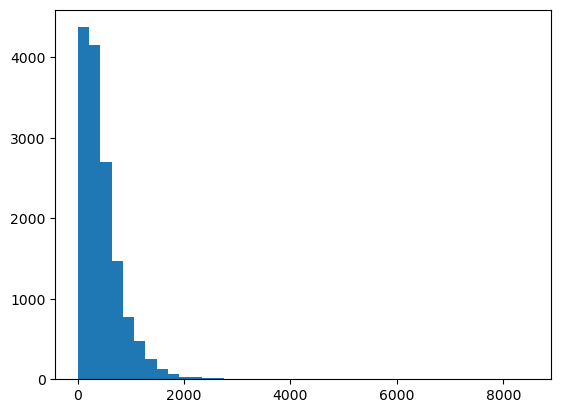

In [7]:
# distribution of number of transactions per consumer
trxn_counts = trxn_df.groupby('prism_consumer_id').count().prism_transaction_id
plt.hist(trxn_counts, bins=40)
plt.show()

In [8]:
# creating separate df for consumers with DQ_TARGET values
cons_df_no_na = cons_df[~cons_df['DQ_TARGET'].isna()]

## Week 1 

**Single best feature to predict `DQ_TARGET`**

**Simple**
- sum of a consumer's `balance`
- `credit_score` seems like an obvious one
- sum of consumer's credit - sum of consumer's debit

In [9]:
# getting outflow (debit) and inflow (credit) categories
debit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'DEBIT']['category'].value_counts().index)
credit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'CREDIT']['category'].value_counts().index)

In [10]:
# creating sum of balances feature
sum_of_balance = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                   .rename(columns={'balance': 'sum_of_balance'}).reset_index()
# use left outer join because we want features for all consumers even if it is NA for now
features_df = cons_df.merge(sum_of_balance, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

In [11]:
features_df

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,sum_of_balance
0,0,2021-09-01,726.0,0.0,320.37
1,1,2021-07-01,626.0,0.0,3302.42
2,2,2021-05-01,680.0,0.0,2805.36
3,3,2021-03-01,734.0,0.0,7667.01
4,4,2021-10-01,676.0,0.0,394.55
...,...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN,NaN
14996,14996,2022-01-15,625.0,NaN,6821.92
14997,14997,2022-01-31,688.0,NaN,NaN
14998,14998,2022-03-08,722.0,NaN,NaN


**Note: balances have different meaning based on account type, i.e. a credit card balance (outflow) vs checkings balance (inflow)**

#### Feature significance metrics

In [12]:
# r2 value for sum of balance feature #
# getting rows where neither features are NA
cons_sum_balance_df_no_na = features_df[(~features_df['DQ_TARGET'].isna()) & (~features_df['sum_of_balance'].isna())]
sum_balance_r2 = np.corrcoef(
        cons_sum_balance_df_no_na['DQ_TARGET'], 
        cons_sum_balance_df_no_na['sum_of_balance']
    )[0][1]**2
sum_balance_r2

0.0015695061588102432

In [13]:
# KS test pvalue for sum of balance feature
cons_sum_balance_dq0 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 0.0]
cons_sum_balance_dq1 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 1.0]
scipy.stats.ks_2samp(cons_sum_balance_dq0["sum_of_balance"], cons_sum_balance_dq1["sum_of_balance"]).pvalue

3.7555463168404585e-99

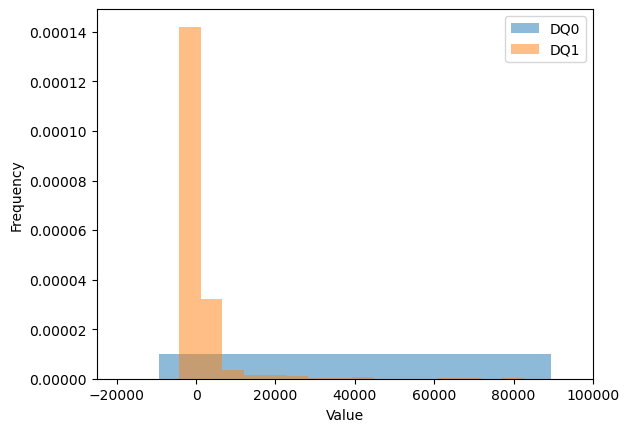

In [14]:
# plotting distributions of sum of balance for delinquent vs nondelinquent consumers
plt.hist(cons_sum_balance_dq0["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_sum_balance_dq1["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-25000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

In [15]:
# r2 value of credit score feature
credit_score_r2 = np.corrcoef(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])[0][1]**2
credit_score_r2

0.06828206045598226

In [16]:
# point biserial value for credit score feature
credit_score_pbr = scipy.stats.pointbiserialr(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])
credit_score_pbr.pvalue

1.5212196313474402e-186

In [17]:
# calculating credit_minus_debit feature
credit_minus_debit = trxn_df.groupby('prism_consumer_id') \
                            .apply(
                                lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()
                                            - group.loc[group["credit_or_debit"] == "DEBIT", "amount"].sum()
                                )

/tmp/ipykernel_347/3454179167.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [18]:
# merging credit_minus_debit feature with features_df
features_df = features_df.merge(pd.DataFrame(credit_minus_debit).reset_index() \
                                          .rename(columns={0: "credit_minus_debit"}), 
                                                 on='prism_consumer_id',
                                                 how='left')
cons_credit_minus_debit_dq0 = features_df[features_df["DQ_TARGET"] == 0.0]
cons_credit_minus_debit_dq0_no_na = cons_credit_minus_debit_dq0[~cons_credit_minus_debit_dq0["credit_minus_debit"].isna()]
cons_credit_minus_debit_dq1 = features_df[features_df["DQ_TARGET"] == 1.0]
cons_credit_minus_debit_dq1_no_na = cons_credit_minus_debit_dq1[~cons_credit_minus_debit_dq1["credit_minus_debit"].isna()]
# calculating KS stat for credit_minus_debit feature for delinquent / nondelinquent consumers
scipy.stats.ks_2samp(cons_credit_minus_debit_dq0_no_na["credit_minus_debit"], cons_credit_minus_debit_dq1_no_na["credit_minus_debit"]).pvalue

1.643182347946055e-26

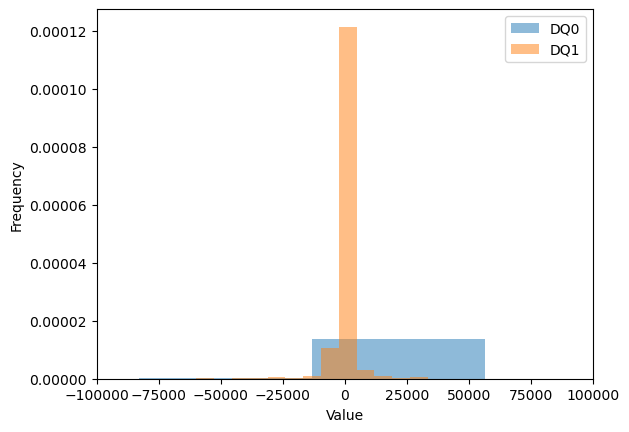

In [19]:
# # plotting distributions of credit_minus_debit for delinquent vs nondelinquent consumers
plt.hist(cons_credit_minus_debit_dq0["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_credit_minus_debit_dq1["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-100000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

## Week 2

**New balance features**
- percent change in balance from earliest date to latest date
- account balance less than 0
  
**New income features**
- number of income transactions
- standard deviation of income
- number of income sources

In [20]:
# should determine the consumers that don't appear in acct_df or trxn_df, remove them from training data

In [21]:
len(cons_df.prism_consumer_id.unique())

15000

In [22]:
len(trxn_df.prism_consumer_id.unique())

14492

In [23]:
len(acct_df.prism_consumer_id.unique())

13009

In [24]:
def calc_balance_delta(rand_cons):
    """
    Calculating change in balance from first transaction to last transaction.
    Args:
        rand_cons (int): consumer id
    Returns:
        float: change in balance
    """
    rand_cons_acct_df = acct_df[acct_df.prism_consumer_id == rand_cons]
    rand_cons_trxn_df = trxn_df[trxn_df.prism_consumer_id == rand_cons].sort_values(by='posted_date')
    
    avg_balance_date = np.mean(rand_cons_acct_df.balance_date)
    balance = sum(rand_cons_acct_df.balance)
    
    before_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date <= avg_balance_date]
    after_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date > avg_balance_date]
    
    initial_balance = balance + sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "DEBIT"].amount) - \
                               sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "CREDIT"].amount) 
    ending_balance = balance + sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "CREDIT"].amount) - \
                               sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "DEBIT"].amount) 
    if initial_balance == 0:
        return 1
    else:
        return ((ending_balance - initial_balance) / initial_balance)

In [25]:
%%time

# growth in balance for each consumer
balance_deltas = cons_df['prism_consumer_id'].apply(calc_balance_delta)

CPU times: user 2min 52s, sys: 1.77 s, total: 2min 54s
Wall time: 1min 13s


In [26]:
# creating balance_delta dataframe and merging with other features generated
balance_delta_df = pd.DataFrame(balance_deltas).reset_index() \
                                               .rename(columns=
                                                       {'index': 'prism_consumer_id', 
                                                        'prism_consumer_id': 'balance_delta'}
                                                      )
features_df = features_df.merge(balance_delta_df, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

In [27]:
# number of "income" sources for each consumer -- TODO: disregard credits that aren't actual income
num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()
num_income_source_df = pd.DataFrame(num_income_sources).reset_index() \
                                .rename(columns=
                                        {'index': 'prism_consumer_id', 
                                         'category': 'num_income_source'}
                                       )
num_income_source_df

,prism_consumer_id,num_income_source
0,0,7
1,1,6
2,2,8
3,3,9
4,4,5
...,...,...
14471,14995,6
14472,14996,6
14473,14997,5
14474,14998,10


In [28]:
# standard deviation of inflows -- TODO: disregard credits that aren't actual income
std_income = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['amount'].std()
std_income_df = pd.DataFrame(std_income).reset_index() \
                                        .rename(columns=
                                            {'index': 'prism_consumer_id', 
                                             'amount': 'income_std'}
                                           )
std_income_df

,prism_consumer_id,income_std
0,0,494.177258
1,1,383.271173
2,2,609.314103
3,3,844.130789
4,4,368.114382
...,...,...
14471,14995,329.312758
14472,14996,1076.542076
14473,14997,2448.997302
14474,14998,1701.940647


In [29]:
# merging num_income_source and std_income features
features_df = features_df.merge(num_income_source_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(std_income_df, on='prism_consumer_id', how='left')
features_df

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,sum_of_balance,credit_minus_debit,balance_delta,num_income_source,income_std
0,0,2021-09-01,726.0,0.0,320.37,-521.59,-0.379272,7.0,494.177258
1,1,2021-07-01,626.0,0.0,3302.42,1805.43,3.245659,6.0,383.271173
2,2,2021-05-01,680.0,0.0,2805.36,430.13,0.203075,8.0,609.314103
3,3,2021-03-01,734.0,0.0,7667.01,2795.24,0.481150,9.0,844.130789
4,4,2021-10-01,676.0,0.0,394.55,-2543.60,-1.421784,5.0,368.114382
...,...,...,...,...,...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN,NaN,-543.80,1.000000,6.0,329.312758
14996,14996,2022-01-15,625.0,NaN,6821.92,878.01,0.147716,6.0,1076.542076
14997,14997,2022-01-31,688.0,NaN,NaN,163.74,1.000000,5.0,2448.997302
14998,14998,2022-03-08,722.0,NaN,NaN,413.80,1.000000,10.0,1701.940647


In [30]:
# creating separate features df for non-NA DQ_TARGET rows
features_df_no_na = features_df[~features_df.DQ_TARGET.isna()]

**NEXT STEPS**
- begin considering category nuances
- more specific time recurrence

## Week 3

In [31]:
# replacing category ints with actual values
cat_mappings = pd.read_csv(Path("../../q2data/q2-ucsd-cat-map.csv"))
cat_mappings = dict(zip(cat_mappings['category_id'], cat_mappings['category']))
trxn_df.category = trxn_df.category.replace(cat_mappings)

In [32]:
trxn_df[trxn_df["credit_or_debit"] == "DEBIT"].category.unique()

array(['SELF_TRANSFER', 'EXTERNAL_TRANSFER', 'ENTERTAINMENT',
       'INVESTMENT', 'FOOD_AND_BEVERAGES', 'GROCERIES', 'FITNESS',
       'GENERAL_MERCHANDISE', 'HEALTHCARE_MEDICAL', 'MISCELLANEOUS',
       'GAMBLING', 'GIFTS_DONATIONS', 'CREDIT_CARD_PAYMENT', 'AUTOMOTIVE',
       'HOME_IMPROVEMENT', 'ATM_CASH', 'TRANSPORATION', 'INSURANCE',
       'ACCOUNT_FEES', 'RENT', 'LOAN', 'BILLS_UTILITIES',
       'ESSENTIAL_SERVICES', 'EDUCATION', 'TRAVEL', 'TAX', 'PETS',
       'MORTGAGE', 'BANKING_CATCH_ALL', 'DEBT', 'AUTO_LOAN', 'BNPL',
       'GOVERNMENT_SERVICES', 'LEGAL', 'RISK_CATCH_ALL',
       'CHILD_DEPENDENTS', 'RTO_LTO', 'OVERDRAFT', 'CORPORATE_PAYMENTS'],
      dtype=object)

In [33]:
def filter_time_window(df, days=None, months=None, years=None):
    """
    Filters transactions for each consumer over some time period
    Args:
        df (pd.DataFrame): dataframe to window over 
        days (int): number of days to go back
        months (int): number of months to go back
        years (int): number of years to go back
    Returns:
        pd.DataFrame: windowed dataframe
    """
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

In [34]:
# creating relevant outflows df with only expenses
debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
outflows_agg_df = trxn_df[~trxn_df['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_agg_df.columns = ['outflows_amt_' + col for col in outflows_agg_df.columns]

In [35]:
outflows_agg_df.head()

,outflows_amt_mean,outflows_amt_std,outflows_amt_median,outflows_amt_min,outflows_amt_max
prism_consumer_id,,,,,
0,68.249895,185.683316,20.000,0.02,1400.00
1,113.418109,275.553072,19.660,0.07,1400.00
2,53.653616,270.477051,13.950,0.00,4694.48
3,102.284215,352.534896,27.100,0.12,4398.00
4,83.476964,174.489962,26.065,0.00,1060.00


In [36]:
# creating filtered window transactions dfs
trxn_df_last_14_days = filter_time_window(trxn_df, days=14)
trxn_df_last_30_days = filter_time_window(trxn_df, days=30)
trxn_df_last_3_months = filter_time_window(trxn_df, months=3)
trxn_df_last_6_months = filter_time_window(trxn_df, months=6)
trxn_df_last_year = filter_time_window(trxn_df, years=1)

/tmp/ipykernel_347/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_347/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_347/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated o

In [37]:
# creating windowed expenses aggregate metrics
outflows_last_14_days_agg_df = trxn_df_last_14_days[~trxn_df_last_14_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_14_days_agg_df.columns = ['outflows_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]

outflows_last_30_days_agg_df = trxn_df_last_30_days[~trxn_df_last_30_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_30_days_agg_df.columns = ['outflows_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]

outflows_last_3_months_agg_df = trxn_df_last_3_months[~trxn_df_last_3_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_3_months_agg_df.columns = ['outflows_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]

outflows_last_6_months_agg_df = trxn_df_last_6_months[~trxn_df_last_6_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_6_months_agg_df.columns = ['outflows_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]

outflows_last_year_agg_df = trxn_df_last_year[~trxn_df_last_year['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_year_agg_df.columns = ['outflows_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

In [38]:
# combining time periods into features df
features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                     [
                         features_df, outflows_agg_df, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df,
                         outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df
                     ])

In [39]:
# creating flags for risky categories
risky_categories = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # removed small dollar advance because no rows have it
trxn_category_table = trxn_df.pivot_table(index='prism_consumer_id', columns='category', values='amount', aggfunc='size', fill_value=0)
gambling_flag_df = pd.DataFrame((trxn_category_table['GAMBLING'] > 0).astype(int)).reset_index()
bnpl_flag_df = pd.DataFrame((trxn_category_table['BNPL'] > 0).astype(int)).reset_index()
overdraft_flag_df = pd.DataFrame((trxn_category_table['OVERDRAFT'] > 0).astype(int)).reset_index()

In [40]:
# combining risky flags into features df
features_df = features_df.merge(gambling_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(bnpl_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(overdraft_flag_df, on='prism_consumer_id', how='left')
features_df

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,sum_of_balance,credit_minus_debit,balance_delta,num_income_source,income_std,outflows_amt_mean,...,outflows_amt_last_6_months_min,outflows_amt_last_6_months_max,outflows_amt_last_year_mean,outflows_amt_last_year_std,outflows_amt_last_year_median,outflows_amt_last_year_min,outflows_amt_last_year_max,GAMBLING,BNPL,OVERDRAFT
0,0,2021-09-01,726.0,0.0,320.37,-521.59,-0.379272,7.0,494.177258,68.249895,...,0.02,1400.00,68.249895,185.683316,20.000,0.02,1400.00,0.0,0.0,0.0
1,1,2021-07-01,626.0,0.0,3302.42,1805.43,3.245659,6.0,383.271173,113.418109,...,0.07,1400.00,113.418109,275.553072,19.660,0.07,1400.00,0.0,1.0,0.0
2,2,2021-05-01,680.0,0.0,2805.36,430.13,0.203075,8.0,609.314103,53.653616,...,0.00,4694.48,53.653616,270.477051,13.950,0.00,4694.48,0.0,0.0,0.0
3,3,2021-03-01,734.0,0.0,7667.01,2795.24,0.481150,9.0,844.130789,102.284215,...,0.12,4398.00,102.284215,352.534896,27.100,0.12,4398.00,0.0,0.0,0.0
4,4,2021-10-01,676.0,0.0,394.55,-2543.60,-1.421784,5.0,368.114382,83.476964,...,0.00,760.00,83.476964,174.489962,26.065,0.00,1060.00,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN,NaN,-543.80,1.000000,6.0,329.312758,85.746118,...,0.22,1321.53,85.746118,172.260628,30.000,0.22,1321.53,0.0,1.0,0.0
14996,14996,2022-01-15,625.0,NaN,6821.92,878.01,0.147716,6.0,1076.542076,184.567762,...,0.01,2000.00,184.567762,379.135402,36.630,0.01,2480.00,0.0,0.0,0.0
14997,14997,2022-01-31,688.0,NaN,NaN,163.74,1.000000,5.0,2448.997302,185.989957,...,0.82,20056.00,185.989957,985.704316,30.000,0.82,20056.00,1.0,0.0,0.0
14998,14998,2022-03-08,722.0,NaN,NaN,413.80,1.000000,10.0,1701.940647,131.465627,...,0.02,3084.03,131.465627,753.889915,26.925,0.02,20706.00,1.0,1.0,1.0


In [41]:
# pulling in balance features (aman) and category features (tracy)
balance_features_df = pd.read_csv('balance_ftrs.csv')
category_features_df = pd.read_csv('category_features.csv')

In [42]:
final_features_df = features_df.merge(balance_features_df, on='prism_consumer_id', how='left')

In [43]:
final_features_df = final_features_df.merge(category_features_df, on='prism_consumer_id', how='left')

In [44]:
final_features_df = final_features_df.drop(columns=['evaluation_date', 'prism_consumer_id'])
final_features_df = final_features_df[~final_features_df['DQ_TARGET'].isna()].fillna(0)

In [45]:
final_features_df

,credit_score,DQ_TARGET,sum_of_balance,credit_minus_debit,balance_delta,num_income_source,income_std,outflows_amt_mean,outflows_amt_std,outflows_amt_median,...,PENSION_last_6_months_std,PENSION_last_6_months_max,PENSION_last_6_months_min,PENSION_last_6_months_count,PENSION_last_year_mean,PENSION_last_year_median,PENSION_last_year_std,PENSION_last_year_max,PENSION_last_year_min,PENSION_last_year_count
0,726.0,0.0,320.37,-521.59,-0.379272,7.0,494.177258,68.249895,185.683316,20.000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,626.0,0.0,3302.42,1805.43,3.245659,6.0,383.271173,113.418109,275.553072,19.660,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,680.0,0.0,2805.36,430.13,0.203075,8.0,609.314103,53.653616,270.477051,13.950,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,734.0,0.0,7667.01,2795.24,0.481150,9.0,844.130789,102.284215,352.534896,27.100,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,676.0,0.0,394.55,-2543.60,-1.421784,5.0,368.114382,83.476964,174.489962,26.065,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,802.0,0.0,1028.80,844.51,4.582506,4.0,72.440995,32.481154,68.245036,4.345,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13996,652.0,0.0,11495.77,-321.80,-0.027231,9.0,680.179827,149.982891,478.504691,42.480,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13997,765.0,0.0,2396.85,47.76,0.020331,6.0,562.410612,372.412250,785.276544,89.865,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13998,685.0,0.0,14835.71,9486.36,1.773367,8.0,1559.836439,252.981069,1026.104596,10.390,...,49.074773,1527.0,1442.0,3.0,1470.333333,1442.0,49.074773,1527.0,1442.0,3.0


In [46]:
# currently using train test split -- need to start using train val test split
X_train, X_test, y_train, y_test = train_test_split(
    final_features_df.drop(columns='DQ_TARGET'), final_features_df['DQ_TARGET'], test_size=0.2, random_state=42
)

In [129]:
def fit_model(X_train, y_train, model_type):
    """
    Fits a machine learning model based on the specified type.

    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): True training values
        model_type (str): Type of model to fit ('log_reg', REST TBD 'random_forest', 'xgboost', 'svm', 'multnb').

    Returns:
        model: Trained model.

    Saves:
        {model_type}_{train/test}_cm.png: confusion matrix of model's accuracy for train and test predictions.
    """

    ###############################
    ## MODEL TRAIN BY MODEL TYPE ##
    ###############################
    
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train, y_train) # TODO: hyperparameter config
    return model

In [95]:
def predict(X, y, model, proba=True, le=None):
    """
    Makes predictions using the trained model and evaluates accuracy.

    Args:
        X (pd.DataFrame): Features for prediction.
        y (pd.Series): True labels to compare predictions.
        model: Trained model (LogisticRegression, RandomForestClassifier, or XGBClassifier).
        proba (bool): True if you want to return the prediction probabilities, else False
        le (LabelEncoder, optional): Label encoder, required for 'xgboost' model.

    Returns:
        preds (numpy.ndarray): Predicted labels.
    """
    preds = model.predict(X)
    if proba:
        preds_proba = model.predict_proba(X)
        return preds, preds_proba
    return preds
    
    # if isinstance(model, XGBClassifier):
    #     preds_encoded = model.predict(X)
    #     preds = le.inverse_transform(preds_encoded)    

In [122]:
def evaluate_model(y, y_pred, y_pred_proba):
    # train metrics
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

In [98]:
model = fit_model(X_train, y_train, 'log_reg')

In [111]:
y_pred_train, y_pred_proba_train = predict(X_train, y_train, model)
y_pred_proba_train = y_pred_proba_train[:, 1]

In [123]:
# train metrics
evaluate_model(y_train, y_pred_train, y_pred_proba_train)

ROC AUC Score: 0.4966
Accuracy: 0.5697

Confusion Matrix:
[[5046 3756]
 [ 375  423]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.57      0.71      8802
         1.0       0.10      0.53      0.17       798

    accuracy                           0.57      9600
   macro avg       0.52      0.55      0.44      9600
weighted avg       0.86      0.57      0.66      9600



In [120]:
y_pred_test, y_pred_proba_test = predict(X_test, y_test, model)
y_pred_proba_test = y_pred_proba_test[:, 1]

In [124]:
# test metrics
evaluate_model(y_test, y_pred_test, y_pred_proba_test)

ROC AUC Score: 0.5126
Accuracy: 0.5854

Confusion Matrix:
[[1281  911]
 [  84  124]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72      2192
         1.0       0.12      0.60      0.20       208

    accuracy                           0.59      2400
   macro avg       0.53      0.59      0.46      2400
weighted avg       0.87      0.59      0.68      2400



In [52]:
feature_weights = list(zip(model.coef_[0], model.feature_names_in_))
feature_weights.sort(reverse=True, key=lambda x: abs(x[0]))
feature_weights

[(-1.2766394852985051e-17, 'balance_delta'),
 (-4.0570851785068703e-26, 'balance_max'),
 (-3.8966468915048323e-26, 'balance_last_year_max'),
 (-3.738323102921626e-26, 'balance_last_6_months_max'),
 (-3.576978999347174e-26, 'outflows_amt_max'),
 (-3.5759511758227574e-26, 'outflows_amt_last_year_max'),
 (-3.445460735588407e-26, 'sum_of_balance'),
 (-3.4273726206203613e-26, 'outflows_amt_last_6_months_max'),
 (-2.702768802831024e-26, 'outflows_amt_last_3_months_max'),
 (-1.8102873594085892e-26, 'balance_last_30_days_max'),
 (-1.694793640627965e-26, 'EXTERNAL_TRANSFER_overall_max'),
 (-1.694793640627965e-26, 'EXTERNAL_TRANSFER_last_year_max'),
 (-1.648318999181588e-26, 'EXTERNAL_TRANSFER_last_6_months_max'),
 (-1.6309209976572182e-26, 'outflows_amt_last_30_days_max'),
 (-1.5389448204367437e-26, 'SELF_TRANSFER_overall_max'),
 (-1.5388713715711858e-26, 'SELF_TRANSFER_last_year_max'),
 (-1.478733657149631e-26, 'SELF_TRANSFER_last_6_months_max'),
 (-1.4081146447523903e-26, 'balance_last_14_day

### Week 5

#### Standardization

In [ ]:
# first -- need to standardize features dataset
# features i should not standardize -- all binary features (GAMBLING, BNPL, OVERDRAFT)

In [77]:
scaler = StandardScaler()
exclude_columns_standardize = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # binary features that shouldn't be standardized
standardize_features = X_train.columns.difference(exclude_columns_standardize)

transformer = ColumnTransformer([
    ('std_scaler', StandardScaler(), standardize_features)  # Standardize all except excluded ones
], remainder='passthrough')

X_train_standardized = transformer.fit_transform(X_train)
X_train_standardized = pd.DataFrame(X_train_standardized, columns=list(standardize_features) + exclude_columns_standardize)

In [134]:
X_test_standardized = transformer.transform(X_test)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=list(standardize_features) + exclude_columns_standardize)

In [130]:
model_standardized = fit_model(X_train_standardized, y_train, 'log_reg')
y_pred_train_standardized, y_pred_proba_train_standardized = predict(X_train_standardized, y_train, model_standardized)
y_pred_proba_train_standardized = y_pred_proba_train_standardized[:, 1]

In [131]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized, y_pred_proba_train_standardized)

ROC AUC Score: 0.9055
Accuracy: 0.9305

Confusion Matrix:
[[8739   63]
 [ 604  194]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      8802
         1.0       0.75      0.24      0.37       798

    accuracy                           0.93      9600
   macro avg       0.85      0.62      0.67      9600
weighted avg       0.92      0.93      0.91      9600



In [135]:
y_pred_test_standardized, y_pred_proba_test_standardized = predict(X_test_standardized, y_test, model_standardized)
y_pred_proba_test_standardized = y_pred_proba_test_standardized[:, 1]

In [136]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized, y_pred_proba_test_standardized)

ROC AUC Score: 0.7073
Accuracy: 0.8900

Confusion Matrix:
[[2120   72]
 [ 192   16]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      2192
         1.0       0.18      0.08      0.11       208

    accuracy                           0.89      2400
   macro avg       0.55      0.52      0.52      2400
weighted avg       0.85      0.89      0.87      2400



#### Feature Selection
- measure by point biserial correlation
- recursive feature elimination (uses model coefficients)
- L1 lasso regularization

In [53]:
# features to add: change in balance over time, binary flags for categories (small dollar advance, gambling, BNPL)